In [5]:
def add(a:int, b:int)->int:
    """
    Add a and b
    Args:
        a(int): first int
        b(int): second int

    return:
        int
    """
    return a+b

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4o")


In [6]:
from langchain_core.messages import HumanMessage
llm_with_tools=llm.bind_tools([add])
llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2", name="Krish")])


AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 74, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_689bad8e9a', 'id': 'chatcmpl-CgYyQB6ZSWonJiM61f153qqoDZS9p', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--a9b86f15-45e4-427c-b656-1fe6a5b9aafe-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_UKXjrrDU7opuYTeGGNL9DitH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 74, 'output_tokens': 17, 'total_tokens': 91, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
from langgraph.graph.message import add_messages, AnyMessage
from typing_extensions import TypedDict
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [8]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish')]

In [9]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [10]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='b207f1db-4f29-40f2-95a3-bcf0b47cf65c'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='84208a14-0f76-4491-95d4-5ddfe3393a29'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='badcd9b0-418c-418c-acf5-50f95a5df742')]

In [11]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [12]:
tools=[add]

In [14]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph, START, END

builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()



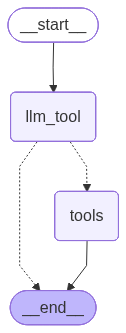

In [16]:
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [18]:
## invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (call_oxaMd8vj3F6VgpkwceS9tt3k)
 Call ID: call_oxaMd8vj3F6VgpkwceS9tt3k
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4
